In [1]:
%pip install graphviz

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Pakete

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import scipy.stats
#from scipy.stats import wilcoxon
import time
#import shap
import xgboost
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier

# Optimale Parameter
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

#SVM
from sklearn import svm
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.inspection import permutation_importance
from sklearn.inspection import DecisionBoundaryDisplay
from matplotlib import cm

from sklearn import datasets
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score




# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation

from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

# Interpretation
import shap
shap.initjs()


In [2]:

# testdaten für die presi holen
import os
os.getcwd()
os.chdir(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

df = pd.read_csv('data/aidsenc.csv', sep =",")

In [3]:
df.shape

(2139, 17)

In [4]:
df.columns

Index(['Unnamed: 0', 'age', 'cd40', 'cid', 'trt_1', 'trt_2', 'trt_3', 'homo_1',
       'drugs_1', 'z30_1', 'gender_1', 'strat_2', 'strat_3', 'symptom_1',
       'hemo_1', 'race_1', 'ecog_1'],
      dtype='object')

In [5]:
# für weitere Tables 'Unnamed' Nummerierung enfernen
df = df.drop(["Unnamed: 0"],axis=1) #,"hemo", "race", "ecog"

# Datensatz für die Modellierung

In [6]:
df.head(5)

,age,cd40,cid,trt_1,trt_2,trt_3,homo_1,drugs_1,z30_1,gender_1,strat_2,strat_3,symptom_1,hemo_1,race_1,ecog_1
0,48,422,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,61,162,1,0,0,1,0,0,1,0,0,1,0,0,0,0
2,45,326,0,0,0,1,1,1,1,1,0,1,0,0,0,0
3,47,287,0,0,0,1,1,0,1,1,0,1,0,0,0,0
4,43,504,0,0,0,0,1,0,1,1,0,1,0,0,0,0


In [7]:
# df1-Datensatz für erste Modellrechnungen erstellen, der unveränderter, encodeder df-Datensatz kann im Verlauf aufgerufen werden
df1 = df

## Datensplitting

In [8]:
X=df1.drop(['cid'],axis=1)
y=df1['cid']

In [9]:
#from sklearn.model_selection import train_test_split
X_fintrain, X_fintest, y_fintrain, y_fintest = train_test_split(X, y, shuffle=True, test_size=0.2,random_state=42)

print('X Train groß: {}'.format(X_fintrain.shape)) 
print('Y Train groß: {}'.format(y_fintrain.shape)) 
print('X Test final: {}'.format(X_fintest.shape)) 
print('Y Test final: {}'.format(y_fintest.shape))


X Train groß: (1711, 15)
Y Train groß: (1711,)
X Test final: (428, 15)
Y Test final: (428,)


## Transformierung mit MinMaxScaler

Die Entscheidung für die Normalisierung (und nicht die Standardisierung) wurde in Anbetracht der Ungewissheit, wie die unbekannten, neuen Test-Daten verteilt werden würden, getroffen.

In [10]:
#from sklearn.preprocessing import MinMaxScaler
mscaler = MinMaxScaler()

X_fintrain['age'] = mscaler.fit_transform(X_fintrain['age'].to_numpy().reshape(-1,1))
X_fintrain['cd40'] = mscaler.fit_transform(X_fintrain['cd40'].to_numpy().reshape(-1,1))

## Erstellen des Validierungsdatensatzes

Der Trainingsdatensatz wird noch ein mal geteilt, um während der Trainingsphase einen Validierungsdatensatz zu haben.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_fintrain, y_fintrain, shuffle=True, test_size=0.2,random_state=42)

print('X Train klein: {}'.format(X_train.shape)) 
print('Y Train klein: {}'.format(y_train.shape)) 
print('X Validierung: {}'.format(X_test.shape)) 
print('Y Validierung: {}'.format(y_test.shape))

X Train klein: (1368, 15)
Y Train klein: (1368,)
X Validierung: (343, 15)
Y Validierung: (343,)


## Hyperparameter

Die Suche nach optimalen `C`, `gamma`, `kernel`, `max_depth` und `n_estimators` wurde mittels Random_Search durchgeführt. GRID-Research und Cross-Validierung dauerte zu lange. 

Per default ist Gamma 'scale', i.e. gamma = 1 / (n_features * X.var()). Es wird überlegt, die `gamma`='scale' statt dem optimierten wert zu nehmen.

<span style=color:green>Nota bene:</span>

`C` (Regularization Parameter): Controls the trade-off between a smooth decision boundary and correctly classifying training points.

`Kernel`: Specifies the function that transforms the input data into a higher-dimensional space to make it linearly separable.

`Gamma (γ)`: Determines how far the influence of a single training example reaches in non-linear kernels like RBF.

Die Doku vom [sklearn.model_selection](https://scikit-learn.org/stable/api/sklearn.model_selection.html).

Die Hyperparameter-Optimierung Modellbetrachtung erfolgt auf Trainingsdaten.

In [12]:

# für LogReg

logistic = LogisticRegression(solver='saga', tol=1e-2, max_iter=200,
                              random_state=0)
distributions = dict(C=uniform(loc=0, scale=4),
                     penalty=['l2', 'l1'])
clf = RandomizedSearchCV(logistic, distributions, random_state=42)
search = clf.fit(X_train, y_train)

print("Die optimalen Hyperparameter für LogReg (Random Search):", search.best_params_)

Die optimalen Hyperparameter für LogReg (Random Search): {'C': np.float64(0.23233444867279784), 'penalty': 'l1'}


In [13]:
# für SVM
param_dist = {
    'C': uniform(loc=0, scale=4),   #[0.1,1,10,100,1000]
    'gamma': [1,0.1,0.01,0.001,0.0001],
    'kernel': ['rbf', 'linear']
}

random_search = RandomizedSearchCV(SVC(random_state=42), param_dist, n_iter=10, refit=True,cv=10,verbose=0,random_state=42) #verbose = 0 : keine einzeln. Messages zu den fits
random_search.fit(X_train,y_train)

print("Die optimalen Hyperparameter für SVM (Random Seaarch):", random_search.best_params_)


Die optimalen Hyperparameter für SVM (Random Seaarch): {'C': np.float64(1.49816047538945), 'gamma': 0.0001, 'kernel': 'rbf'}


In [14]:
# für RF
param_dist = {'n_estimators': randint(10,300),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, param_distributions = param_dist, n_iter=5, cv=10, random_state=42)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000218A8107310>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000218A80DCDC0>},
                   random_state=42)

Für optimale Hyperparameter bräuchte es theoretisch keinen 2. Split für Validierungsdaten, da `RandomizedSearch` `cv` (Krossvalidierung) verwendet. Allerdings werde ich die Validierungsdaten in der trainingsphase nach der Modellauswahl brauchen.

In [15]:
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Die optimalen Hyperparameter für RF (Random Search):',  rand_search.best_params_)

Die optimalen Hyperparameter für RF (Random Search): {'max_depth': 7, 'n_estimators': 280}


## Die Auswahl des Classifikators

Für FR kann hier kein `best_rf.predict()` verwendet werden, es wird über die Einstellung einzelner Hyperparameter daraus erreicht.

In [16]:
n_features = X.shape[1]

#C = 2.2

# Create different classifiers.
classifiers = {
    "L1 logistic": LogisticRegression(C=0.2, penalty="l1", solver="saga", max_iter=10000, random_state=42),
    
    "Linear SVC": SVC(kernel="linear", C=1.5, probability=True, random_state=42),
    
    "RBF SVC": SVC(kernel="rbf", C=1.5, gamma=0.0001, random_state=42),
    
    "Random Forest": RandomForestClassifier(max_depth=7, n_estimators=280, random_state=42)
}

for classifier_idx, (name, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    print(f"Trainingsdaten, Akkuranz für {name}: {accuracy:0.2%}")
    print(f"Trainingsdaten, Precision für {name}: {precision:0.2%}")
    print(f"Trainingsdaten, Recall für {name}: {recall:0.2%}")
    

Trainingsdaten, Akkuranz für L1 logistic: 74.05%
Trainingsdaten, Precision für L1 logistic: 50.00%
Trainingsdaten, Recall für L1 logistic: 2.25%
Trainingsdaten, Akkuranz für Linear SVC: 74.05%
Trainingsdaten, Precision für Linear SVC: 0.00%
Trainingsdaten, Recall für Linear SVC: 0.00%
Trainingsdaten, Akkuranz für RBF SVC: 74.05%
Trainingsdaten, Precision für RBF SVC: 0.00%
Trainingsdaten, Recall für RBF SVC: 0.00%
Trainingsdaten, Akkuranz für Random Forest: 75.22%
Trainingsdaten, Precision für Random Forest: 59.09%
Trainingsdaten, Recall für Random Forest: 14.61%


### gamma = 'scale'

In [17]:
# mit gamma = 'scale'
n_features = X.shape[1]

#C = 2.2

# Create different classifiers.
classifiers = {
    "L1 logistic": LogisticRegression(C=0.2, penalty="l1", solver="saga", max_iter=10000, random_state=42),
    
    "Linear SVC": SVC(kernel="linear", C=1.5, probability=True, random_state=42),
    
    "RBF SVC": SVC(kernel="rbf", C=1.5, gamma="scale", random_state=42),
    
    "Random Forest": RandomForestClassifier(max_depth=7, n_estimators=280, random_state=42)
}

for classifier_idx, (name, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    print(f"Trainingsdaten, Akkuranz für {name}: {accuracy:0.2%}")
    print(f"Trainingsdaten, Precision für {name}: {precision:0.2%}")
    print(f"Trainingsdaten, Recall für {name}: {recall:0.2%}")
    

Trainingsdaten, Akkuranz für L1 logistic: 74.05%
Trainingsdaten, Precision für L1 logistic: 50.00%
Trainingsdaten, Recall für L1 logistic: 2.25%
Trainingsdaten, Akkuranz für Linear SVC: 74.05%
Trainingsdaten, Precision für Linear SVC: 0.00%
Trainingsdaten, Recall für Linear SVC: 0.00%
Trainingsdaten, Akkuranz für RBF SVC: 74.05%
Trainingsdaten, Precision für RBF SVC: 50.00%
Trainingsdaten, Recall für RBF SVC: 4.49%
Trainingsdaten, Akkuranz für Random Forest: 75.22%
Trainingsdaten, Precision für Random Forest: 59.09%
Trainingsdaten, Recall für Random Forest: 14.61%


Tendenz zu `gamma`= 'scale'. ==> bessere Precision und Recall.

<span style=color:green>Precision steigern:</span> Random Forest und RBF-SVC auf feature importnace / permutation importance anschauen. ==> ggf. Die Daten noch ein Mal reduzieren.

## Support Vector Machine: RBF-Kernel

`C` ist ein Regulierungsparameter. [Doku](https://scikit--learn-org.translate.goog/1.5/auto_examples/svm/plot_svm_scale_c.html?_x_tr_sl=en&_x_tr_tl=de&_x_tr_hl=de&_x_tr_pto=rq#sphx-glr-auto-examples-svm-plot-svm-scale-c-py) dazu. Die Anpassung von `C`, `gamma`und `kernel` s.o. 


Nota bene: [Enscheidungsgrenzen für das SVC anzeichnen](https://scikit--learn-org.translate.goog/1.5/auto_examples/svm/plot_svm_kernels.html?_x_tr_sl=en&_x_tr_tl=de&_x_tr_hl=de&_x_tr_pto=rq#sphx-glr-auto-examples-svm-plot-svm-kernels-py) dienen der Visualisierung der grundsätzlichen Wirkung des Kernels auf Daten. 

              precision    recall  f1-score   support

           0       0.98      0.75      0.85       335
           1       0.04      0.50      0.08         8

    accuracy                           0.74       343
   macro avg       0.51      0.62      0.47       343
weighted avg       0.96      0.74      0.83       343



Text(0.5, 0, 'Permutation Importance Trainingsdaten')

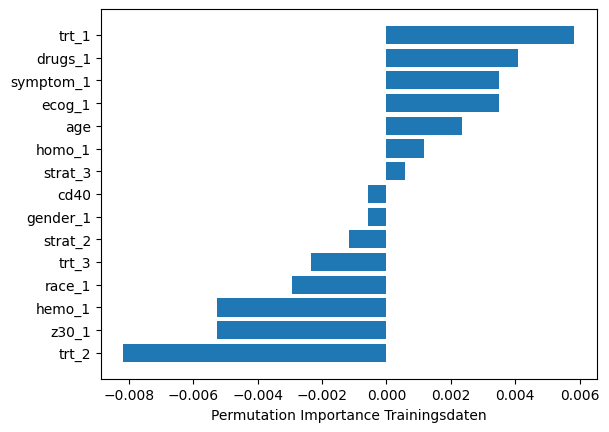

In [18]:
from sklearn.metrics import classification_report

clf =  SVC(kernel='rbf', C=1.5, gamma='scale', random_state=42)
clf.fit(X_train, y_train)
y_pred2 = clf.predict(X_test)

print(classification_report(y_pred2, y_test))

perm_importance = permutation_importance(clf, X_test, y_test)

feature_names = X_train.columns
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance Trainingsdaten")

#'permutation importance' gibt wieder, wie wichtig ein feature für das vorliegende Modell ist.
# bei RBF sind die 'coef' nicht verfügbar. - keine feature importance.

A negative coefficient means that higher value of the corresponding feature pushes the classification more towards the negative class. 'negative class' ist in diesem Fall 'censoring' also 'überlebt'

In [19]:
#Accuracy im Traings- und Validierungsdatensatz
# wie gut wurde getrennt? 

print("Akkuranz Train klein: {}".format(clf.score(X_train, y_train)))
print("Akkuranz Validierung: {}" .format(clf.score(X_test, y_test)))

Akkuranz Train klein: 0.7814327485380117
Akkuranz Validierung: 0.7405247813411079


Der Unterschied mit 0.04 Punkten ist reltiv groß == mässiger Splitting

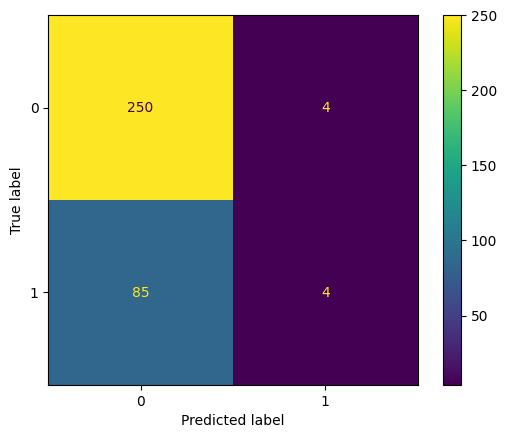

In [ ]:
# Generate predictions with the best model
#y_pred = clf.predict(X_test)

# Create the confusion matrix
cm2 = confusion_matrix(y_test, y_pred2)

ConfusionMatrixDisplay(cm2).plot();

## Random Forest

In [23]:
rf = RandomForestClassifier(max_depth=7, n_estimators=280, random_state=42)
rf.fit(X_train, y_train)
y_pred3 = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred3)

print("Trenningsdaten, Akkuranz RF Modell:", accuracy)

print(classification_report(y_pred3, y_test))

Trenningsdaten, Akkuranz RF Modell: 0.7521865889212828
              precision    recall  f1-score   support

           0       0.96      0.76      0.85       321
           1       0.15      0.59      0.23        22

    accuracy                           0.75       343
   macro avg       0.56      0.68      0.54       343
weighted avg       0.91      0.75      0.81       343



`classification_report` liefert maue *Precision* sowohl für SVM als auch für RF <span style=color:red> für das Target = 1 (failure)</span>. Das ist ein deutlicher Hinweis auf unsymetrische Daten. Auch die Akkuranz ist mittelmässig.

Der nächste Schritt ist es, unwichtige Features auszusortiren.

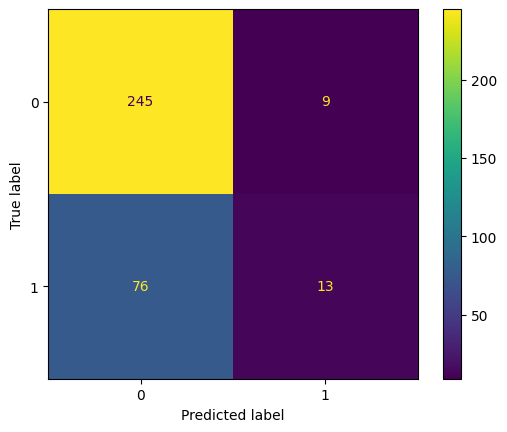

In [25]:
# Generate predictions with the best model
#y_pred = best_rf.predict(X_test)

# Create the confusion matrix
cm3 = confusion_matrix(y_test, y_pred3)

ConfusionMatrixDisplay(cm3).plot();

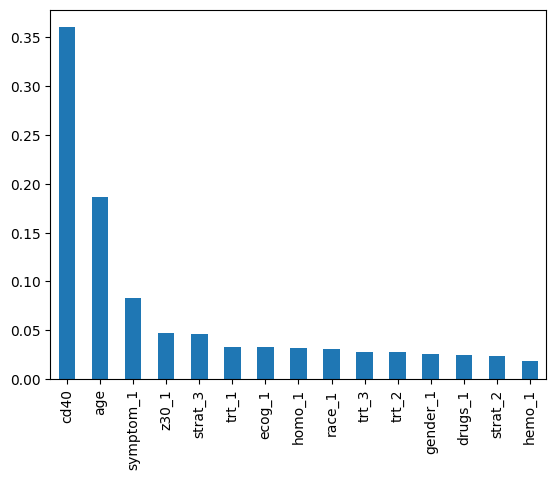

In [26]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

#plot
feature_importances.plot.bar();

In [27]:
print(feature_importances)

cd40         0.360250
age          0.186721
symptom_1    0.083202
z30_1        0.047370
strat_3      0.045956
trt_1        0.032929
ecog_1       0.032418
homo_1       0.031534
race_1       0.030830
trt_3        0.027960
trt_2        0.027297
gender_1     0.025486
drugs_1      0.025131
strat_2      0.023866
hemo_1       0.019049
dtype: float64


# Datensatz 2. Reduktion

Nachfolgend werden die Features anhand von *feature importance / permutation* und nach inhaltlichen Überlegungen (domane Wissen) aus der weiteren Modellierung entfernt.

In [28]:
X_train.columns

Index(['age', 'cd40', 'trt_1', 'trt_2', 'trt_3', 'homo_1', 'drugs_1', 'z30_1',
       'gender_1', 'strat_2', 'strat_3', 'symptom_1', 'hemo_1', 'race_1',
       'ecog_1'],
      dtype='object')

In [29]:
X_train2=X_train.drop(["hemo_1", "homo_1", "race_1", "ecog_1", "gender_1"],axis=1) #,

In [30]:
X_test2=X_test.drop(["hemo_1", "homo_1", "race_1", "ecog_1", "gender_1"],axis=1) #,

In [31]:
X_train2.head(7)

,age,cd40,trt_1,trt_2,trt_3,drugs_1,z30_1,strat_2,strat_3,symptom_1
1036,0.517241,0.357798,0,0,1,0,1,1,0,0
2015,0.086207,0.323603,0,0,1,0,1,0,1,0
1580,0.724138,0.287740,0,0,1,0,1,0,1,0
287,0.327586,0.224354,0,0,0,0,1,1,0,1
805,0.258621,0.386989,1,0,0,0,0,0,0,0
1997,0.482759,0.341952,0,0,0,0,1,0,1,0
460,0.379310,0.281068,1,0,0,0,0,0,0,0


## Hyperparameter

Die Suche nach optimalen `C`, `gamma`, `kernel`, `max_depth` und `n_estimators` wird auch im 2. Gang mittels Random_Search durchgeführt. Es werden nun nur RBF-SVC und Random Forest optimiert.

In [33]:
# für SVM
param_dist = {
    'C': uniform(loc=0, scale=4),   #[0.1,1,10,100,1000]
    'gamma': [1,0.1,0.01,0.001,0.0001],
    'kernel': ['rbf', 'linear']
}

random_search = RandomizedSearchCV(SVC(random_state=42), param_dist, n_iter=10, refit=True,cv=10,verbose=0,random_state=42) #verbose = 0 : keine einzeln. Messages zu den fits
random_search.fit(X_train2,y_train)

print("Die optimalen Hyperparameter für SVM (Random Seaarch):", random_search.best_params_)


Die optimalen Hyperparameter für SVM (Random Seaarch): {'C': np.float64(1.49816047538945), 'gamma': 0.0001, 'kernel': 'rbf'}


In [34]:
# für RF
param_dist = {'n_estimators': randint(10,300),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, param_distributions = param_dist, n_iter=5, cv=10, random_state=42)

# Fit the random search object to the data
rand_search.fit(X_train2, y_train)

RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000218AA129FA0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000218AA114910>},
                   random_state=42)

In [35]:
best_rf2 = rand_search.best_estimator_

# Print the best hyperparameters
print('Die optimalen Hyperparameter für RF (Random Search):',  rand_search.best_params_)

Die optimalen Hyperparameter für RF (Random Search): {'max_depth': 7, 'n_estimators': 280}


## Die Auswahl des Classifikators

### gamma = 'scale'

In [36]:
n_features = X.shape[1]

# Create different classifiers.
classifiers = {
    "RBF SVC": SVC(kernel="rbf", C=1.5, gamma='scale', random_state=42),
    
    "Random Forest": RandomForestClassifier(max_depth=7, n_estimators=280, random_state=42)
}

for classifier_idx, (name, classifier) in enumerate(classifiers.items()):
    y2_pred = classifier.fit(X_train2, y_train).predict(X_test2)
    accuracy2 = accuracy_score(y_test, y2_pred)
    precision2 = precision_score(y_test, y2_pred)
    recall2 = recall_score(y_test, y2_pred)
    
    print(f"Trainingsdaten 2, Akkuranz für {name}: {accuracy2:0.2%}")
    print(f"Trainingsdaten 2, Precision für {name}: {precision2:0.2%}")
    print(f"Trainingsdaten 2, Recall für {name}: {recall2:0.2%}")    

Trainingsdaten 2, Akkuranz für RBF SVC: 73.76%
Trainingsdaten 2, Precision für RBF SVC: 44.44%
Trainingsdaten 2, Recall für RBF SVC: 4.49%
Trainingsdaten 2, Akkuranz für Random Forest: 74.93%
Trainingsdaten 2, Precision für Random Forest: 55.17%
Trainingsdaten 2, Recall für Random Forest: 17.98%


Die Tendenz geht zu Random Forest. ==> bessere Precision und Recall.

<span style=color:green>Prefinale Entscheidung:</span> Noch ein Mal Random Forest auf feature importnace anschauen. ==> Ob der Wackelkandidat `drugs_1` sich verbessert hat. Wenn keines der Features entschieden an Einfluss gewonnen hat, noch ein Mal Features reduzieren, trainieren und das finale Modell evaluieren und fertigstellen.

## Modellentscheidung: Random Forest

In [40]:
#rf2 = RandomForestClassifier(max_depth=7, n_estimators=280, random_state=42)
best_rf2.fit(X_train2, y_train)
y22_pred = best_rf2.predict(X_test2)
accuracy22 = accuracy_score(y_test, y22_pred)

print("Trenningsdaten, Akkuranz RF Modell:", accuracy22)

print(classification_report(y22_pred, y_test))

Trenningsdaten, Akkuranz RF Modell: 0.7405247813411079
              precision    recall  f1-score   support

           0       0.94      0.76      0.84       313
           1       0.17      0.50      0.25        30

    accuracy                           0.74       343
   macro avg       0.55      0.63      0.55       343
weighted avg       0.87      0.74      0.79       343



`classification_report` liefert eine **etwas bessere** *Precision* und *Supporter* für RF für das Target = 1 (failure).

In [41]:
#Accuracy im Traings- und Testdatensatz
# wie gut wurde getrennt? Der Unterschied ist nicht groß == guter Spliting

print("Akkuranz RF Train klein: {}".format(best_rf2.score(X_train2, y_train)))
print("Akkuranz RF Validierung: {}" .format(best_rf2.score(X_test2, y_test)))

Akkuranz RF Train klein: 0.8318713450292398
Akkuranz RF Validierung: 0.7405247813411079


Der Unterschied hat sich vergrössert. Ein Hinweis auf `Overfit`.

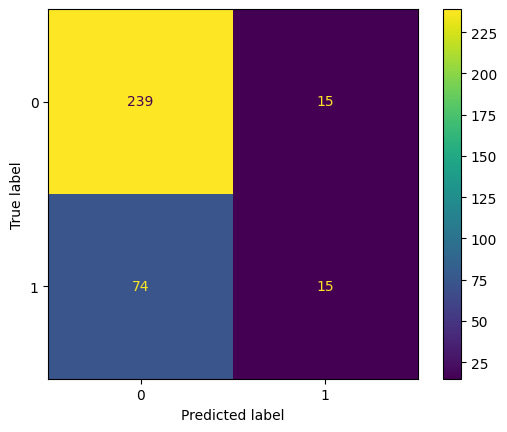

In [42]:
# Generate predictions with the best model
y23_pred = best_rf2.predict(X_test2)

# Create the confusion matrix
cm3 = confusion_matrix(y_test, y23_pred)

ConfusionMatrixDisplay(cm3).plot();

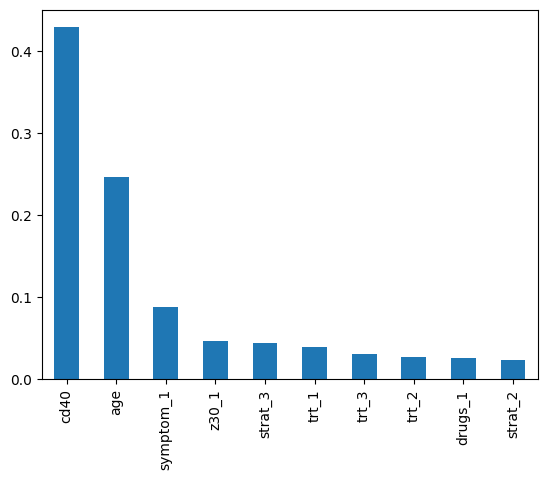

In [43]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances2 = pd.Series(best_rf2.feature_importances_, index=X_train2.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances2.plot.bar();

In [44]:
print(feature_importances2)

cd40         0.429235
age          0.245991
symptom_1    0.087520
z30_1        0.047019
strat_3      0.044115
trt_1        0.039523
trt_3        0.030596
trt_2        0.026997
drugs_1      0.025911
strat_2      0.023093
dtype: float64


## 3. Datenreduktion

Hier soll für das Random Forest der Datensatz anhand der Feature Importance noch ein Mal reduziert werden. So scheidet `drugs_1` raus.

In [47]:
X_test2.columns

Index(['age', 'cd40', 'trt_1', 'trt_2', 'trt_3', 'drugs_1', 'z30_1', 'strat_2',
       'strat_3', 'symptom_1'],
      dtype='object')

In [48]:
X_train3=X_train2.drop(["drugs_1"],axis=1) #,
X_test3=X_test2.drop(["drugs_1"],axis=1) #,

In [49]:
# für RF
param_dist = {'n_estimators': randint(10,300),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf3 = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search3 = RandomizedSearchCV(rf3, param_distributions = param_dist, n_iter=5, cv=10, random_state=42)

# Fit the random search object to the data
rand_search3.fit(X_train3, y_train)

RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000218AA1F1880>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000218AAA1F7C0>},
                   random_state=42)

In [50]:
best_rf3 = rand_search3.best_estimator_

# Print the best hyperparameters
print('Die optimalen Hyperparameter für RF (Random Search):',  rand_search3.best_params_)

Die optimalen Hyperparameter für RF (Random Search): {'max_depth': 7, 'n_estimators': 131}


In [51]:
#rf2 = RandomForestClassifier(max_depth=7, n_estimators=280, random_state=42)
best_rf3.fit(X_train3, y_train)
y23_pred = best_rf3.predict(X_test3)
accuracy23 = accuracy_score(y_test, y23_pred)

print("Trenningsdaten, Akkuranz RF Modell:", accuracy23)

print(classification_report(y23_pred, y_test))

Trenningsdaten, Akkuranz RF Modell: 0.7405247813411079
              precision    recall  f1-score   support

           0       0.93      0.77      0.84       309
           1       0.19      0.50      0.28        34

    accuracy                           0.74       343
   macro avg       0.56      0.63      0.56       343
weighted avg       0.86      0.74      0.79       343



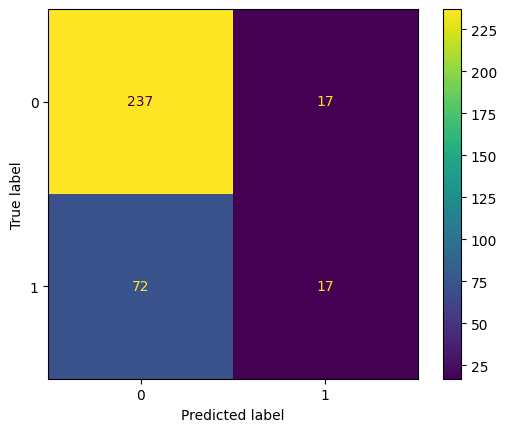

In [52]:
# Generate predictions with the best model
#y_pred = best_rf.predict(X_test)

# Create the confusion matrix
cm4 = confusion_matrix(y_test, y23_pred)

ConfusionMatrixDisplay(cm4).plot();

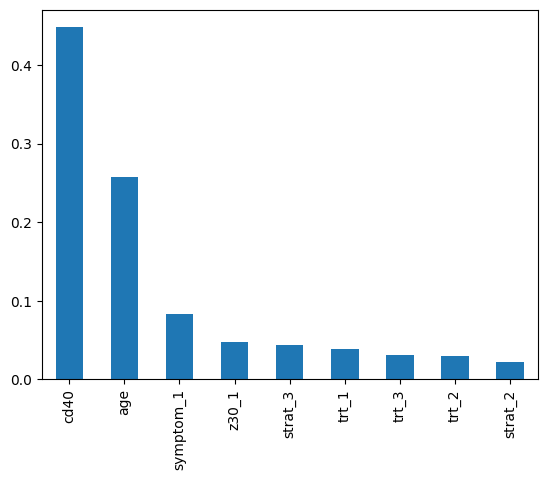

In [54]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances3 = pd.Series(best_rf3.feature_importances_, index=X_train3.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances3.plot.bar();

In [55]:
print(feature_importances3)

cd40         0.448176
age          0.257612
symptom_1    0.083454
z30_1        0.046700
strat_3      0.043091
trt_1        0.038933
trt_3        0.030875
trt_2        0.029732
strat_2      0.021426
dtype: float64


# Evaluation des Modells mit Testdaten

In [56]:
X_fintrain=X_fintrain.drop(["hemo_1", "homo_1", "race_1", "ecog_1", "gender_1", "drugs_1"],axis=1) #,

In [57]:
X_fintest=X_fintest.drop(["hemo_1", "homo_1", "race_1", "ecog_1", "gender_1", "drugs_1"],axis=1) #,

### Random Forest

In [58]:
#rffin = RandomForestClassifier(max_depth=7, n_estimators=280, random_state=42)
best_rf3.fit(X_fintrain, y_fintrain)
y_pred = best_rf3.predict(X_fintest)
accuracy = accuracy_score(y_fintest, y_pred)

print("Testdaten, Akkuranz Random Forest:", accuracy)

print(classification_report(y_pred, y_fintest))

Testdaten, Akkuranz Random Forest: 0.7546728971962616
              precision    recall  f1-score   support

           0       0.98      0.76      0.86       420
           1       0.02      0.25      0.04         8

    accuracy                           0.75       428
   macro avg       0.50      0.51      0.45       428
weighted avg       0.96      0.75      0.84       428



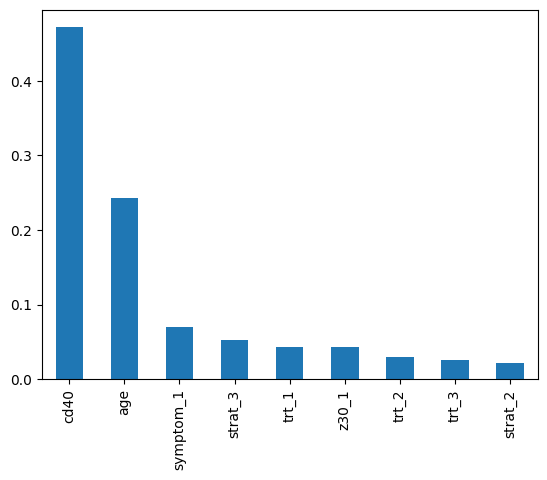

In [59]:
# Create a series containing feature importances from the model and feature names from the training data
fin_feature_importances = pd.Series(best_rf3.feature_importances_, index=X_fintest.columns).sort_values(ascending=False)

# Plot a simple bar chart
fin_feature_importances.plot.bar();

In [61]:
print(fin_feature_importances)

cd40         0.471735
age          0.242633
symptom_1    0.070266
strat_3      0.052198
trt_1        0.043012
z30_1        0.042662
trt_2        0.030033
trt_3        0.025878
strat_2      0.021583
dtype: float64


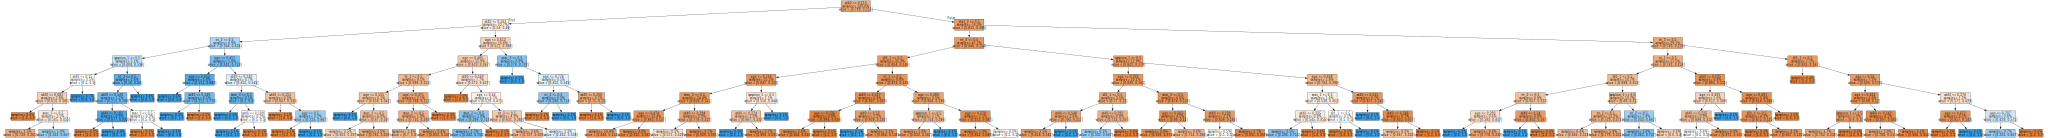

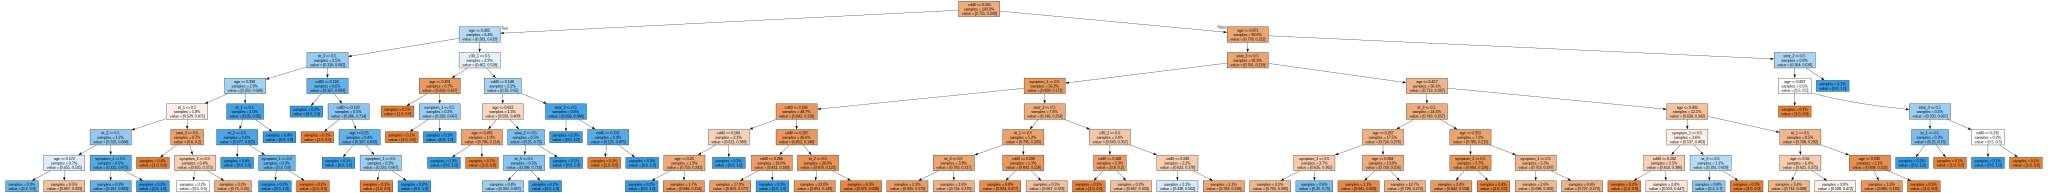

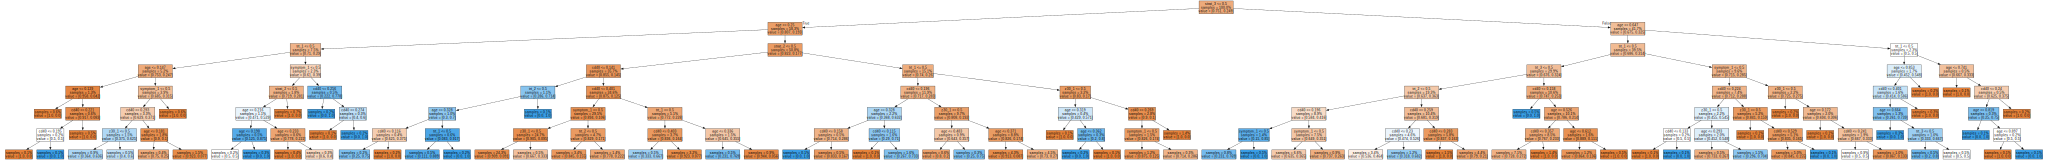

In [62]:
# Export the first three decision trees from the forest

for i in range(3):
    tree = best_rf3.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_fintest.columns,  
                               filled=True,  
                               max_depth=7, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)